In [1]:
# ------------------------------------------------
# 
# sil vs cc data, plotting the intial R and E, 
# then R minus E for the more and less acidic 
# cases
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# FERT LEVEL 1 
fertLevel_1 = "hi"
idx_1 = "001" # [(no tag): 009=0.2 ton cc/ha/yr; 012=0.5 ton cc/ha/yr; 002=0.8 ton cc/ha/yr; 011=1.4 ton cc/ha/yr] 
tag_sil_1 = "basev11a" # "basev3_multiCTRL"

# FERT LEVEL 2
fertLevel_2 = "low"
idx_2 = "001" # [(no tag): 009=0.2 ton cc/ha/yr; 012=0.5 ton cc/ha/yr; 002=0.8 ton cc/ha/yr; 011=1.4 ton cc/ha/yr] 
tag_sil_2 = "basev11a"   # "basev3_multiCTRL"

In [2]:
# ---- READ IN DATA
# CASE 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))
# # read in profile data
# dssil1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
# dscc1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
# dssil1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
# dscc1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))

# CASE 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))
# # read in profile data
# dssil2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
# dscc2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
# dssil2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
# dscc2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))

In [11]:
dssil1

<xarray.Dataset> Size: 484kB
Dimensions:                       (loss_percent: 50, dustrate_ton_ha_yr: 14,
                                   dustrad: 10)
Coordinates:
  * loss_percent                  (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr            (dustrate_ton_ha_yr) float64 112B 0.1 ... 1...
  * dustrad                       (dustrad) int32 40B 1 10 30 50 ... 150 200 300
Data variables: (12/47)
    cdr_dif                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    cdr_adv                       (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    cdr_adv_plus_newSIC           (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    cdr_SIConly                   (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    co2pot_tot_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    co2pot_adv_tonHa_camg         (dustrad, dustrate_ton_ha_yr, loss_percent) float64 56kB ...
    ...                            ...
    time_horizon                  float64 8B ...
    truck_km                      float64 8B ...
    barge_km                      float64 8B ...
    barge_diesel_km               int32 4B ...
    p80_input                     float64 8B ...
    bondwork_index                float64 8B ...
Attributes:
    flx_type:  int_flx

(0.2, 80)

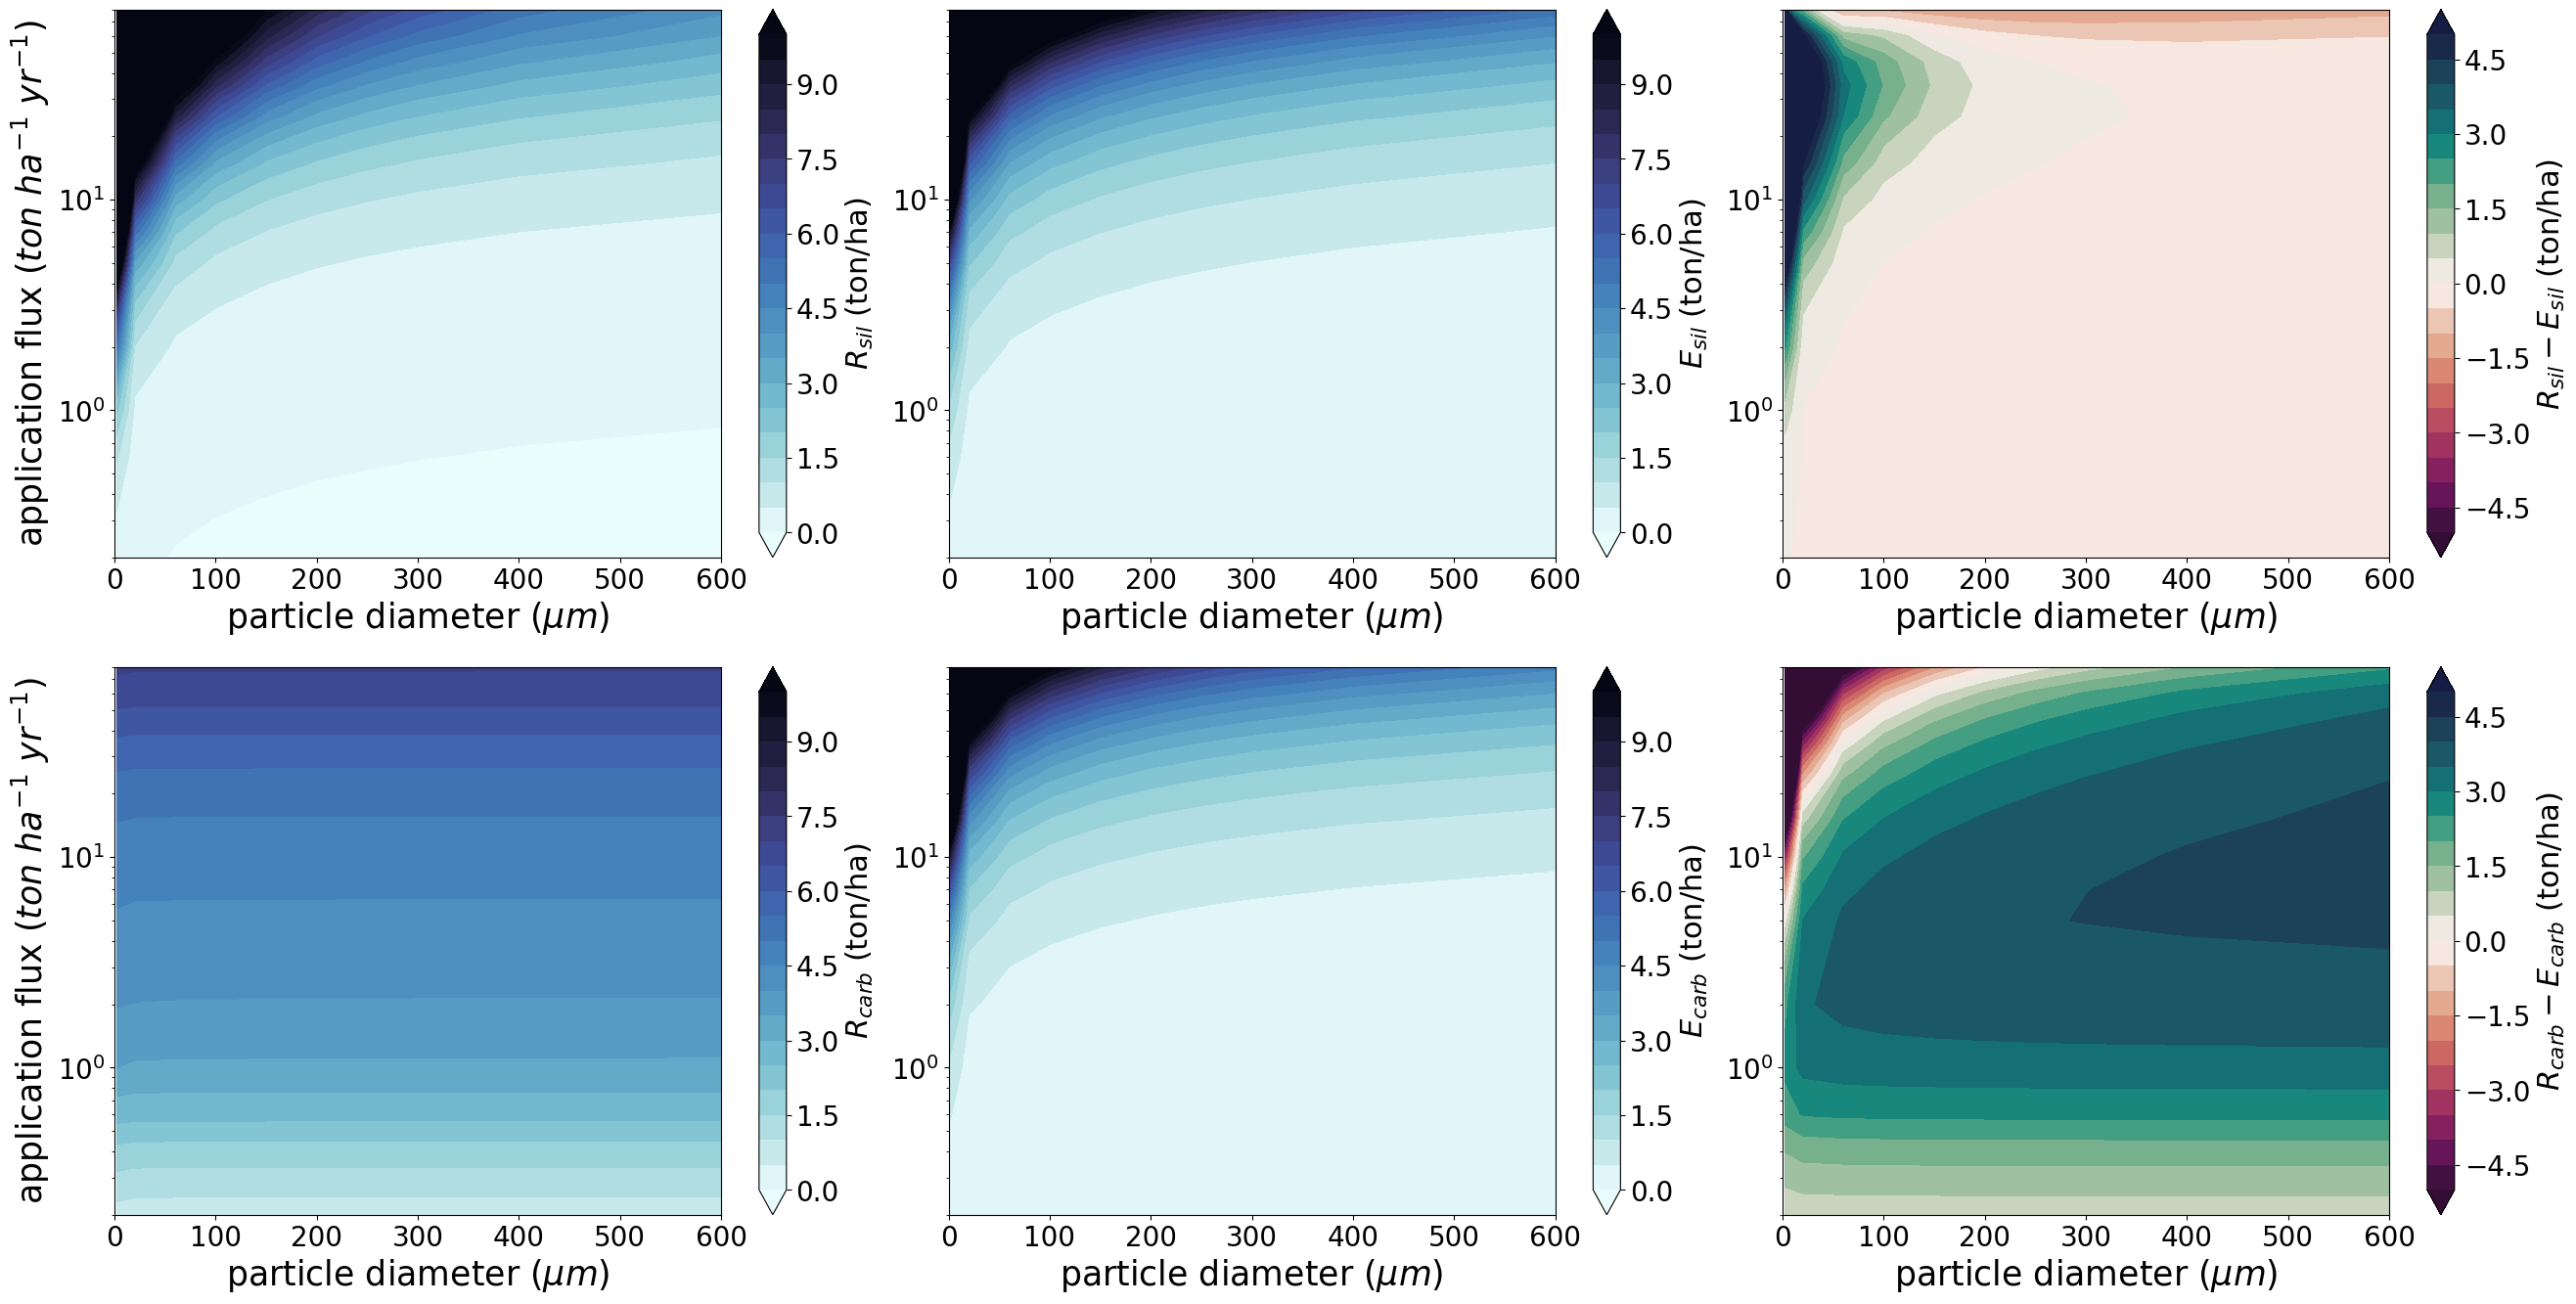

In [44]:
# --- PLOT decompose the silicate R and E 
# LOWFERT ONLY
# set data conditions
loss_percent = 0
r_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg'  # 'co2pot_tot_tonHa_camg'
e_var = 'E_total_tonCO2_ha'
logX = False
logY = True

# pull out the data we want
dssil2_r = dssil2.sel(loss_percent=loss_percent, method='nearest')[r_var]
dssil2_e = dssil2.sel(loss_percent=loss_percent, method='nearest')[e_var]
dscc2_r = dscc2.sel(loss_percent=loss_percent, method='nearest')[r_var]
dscc2_e = dscc2.sel(loss_percent=loss_percent, method='nearest')[e_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil2_r = dssil2_r.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_e = dssil2_e.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_r = dscc2_r.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_e = dscc2_e.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col_r = cmo.ice_r
col_e = cmo.ice_r
col_net = cmo.curl_r 
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin_r, cmax_r = 0, 10
cmin_e, cmax_e = 0, 10
cmin_net, cmax_net = -5, 5
cbar_extend_r = "both"    # both, max, or min
cbar_extend_e = "both"    # both, max, or min
cbar_extend_net = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 80 
# *****************************

# x and y arrays
# [fertlevel 2]
xcc2 = dscc2_r['dustrad'].values
ycc2 = dscc2_r['dustrate_ton_ha_yr'].values
xsil2 = dssil2_r['dustrad'].values
ysil2 = dssil2_r['dustrate_ton_ha_yr'].values



# --- SET UP PLOT
spec = GridSpec(ncols=3, nrows=2, wspace=0.1)
fig = plt.figure(figsize=(32,16))

# --- fert level 2, sil, removal
ax = plt.subplot(spec[0])
contour = plt.contourf(xsil2*2, ysil2, dssil2_r.transpose(), levels=np.linspace(cmin_r, cmax_r, 21), 
                        cmap = col_r, vmin=cmin_r, vmax=cmax_r, extend=cbar_extend_r)
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fert level 2, sil, emissions
ax = plt.subplot(spec[1])
contour = plt.contourf(xsil2*2, ysil2, dssil2_e.transpose(), levels=np.linspace(cmin_e, cmax_e, 21), 
                        cmap = col_e, vmin=cmin_e, vmax=cmax_e, extend=cbar_extend_e)
cbar = plt.colorbar(contour)
cbar.set_label(r'$E_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fert level 2, sil, R minus E
ax = plt.subplot(spec[2])
contour = plt.contourf(xsil2*2, ysil2, dssil2_r.transpose() - dssil2_e.transpose(), levels=np.linspace(cmin_net, cmax_net, 21), 
                        cmap = col_net, vmin=cmin_net, vmax=cmax_net, extend=cbar_extend_net)
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{sil} - E_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)



# --- fert level 2, cc, removal
ax = plt.subplot(spec[3])
contour = plt.contourf(xcc2*2, ycc2, dscc2_r.transpose(), levels=np.linspace(cmin_r, cmax_r, 21), 
                        cmap = col_r, vmin=cmin_r, vmax=cmax_r, extend=cbar_extend_r)
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{carb}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fert level 2, cc, emissions
ax = plt.subplot(spec[4])
contour = plt.contourf(xcc2*2, ycc2, dscc2_e.transpose(), levels=np.linspace(cmin_e, cmax_e, 21), 
                        cmap = col_e, vmin=cmin_e, vmax=cmax_e, extend=cbar_extend_e)
cbar = plt.colorbar(contour)
cbar.set_label(r'$E_{carb}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fert level 2, cc, R minus E
ax = plt.subplot(spec[5])
contour = plt.contourf(xcc2*2, ycc2, dscc2_r.transpose() - dscc2_e.transpose(), levels=np.linspace(cmin_net, cmax_net, 21), 
                        cmap = col_net, vmin=cmin_net, vmax=cmax_net, extend=cbar_extend_net)
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{carb} - E_{carb}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


(0.2, 80)

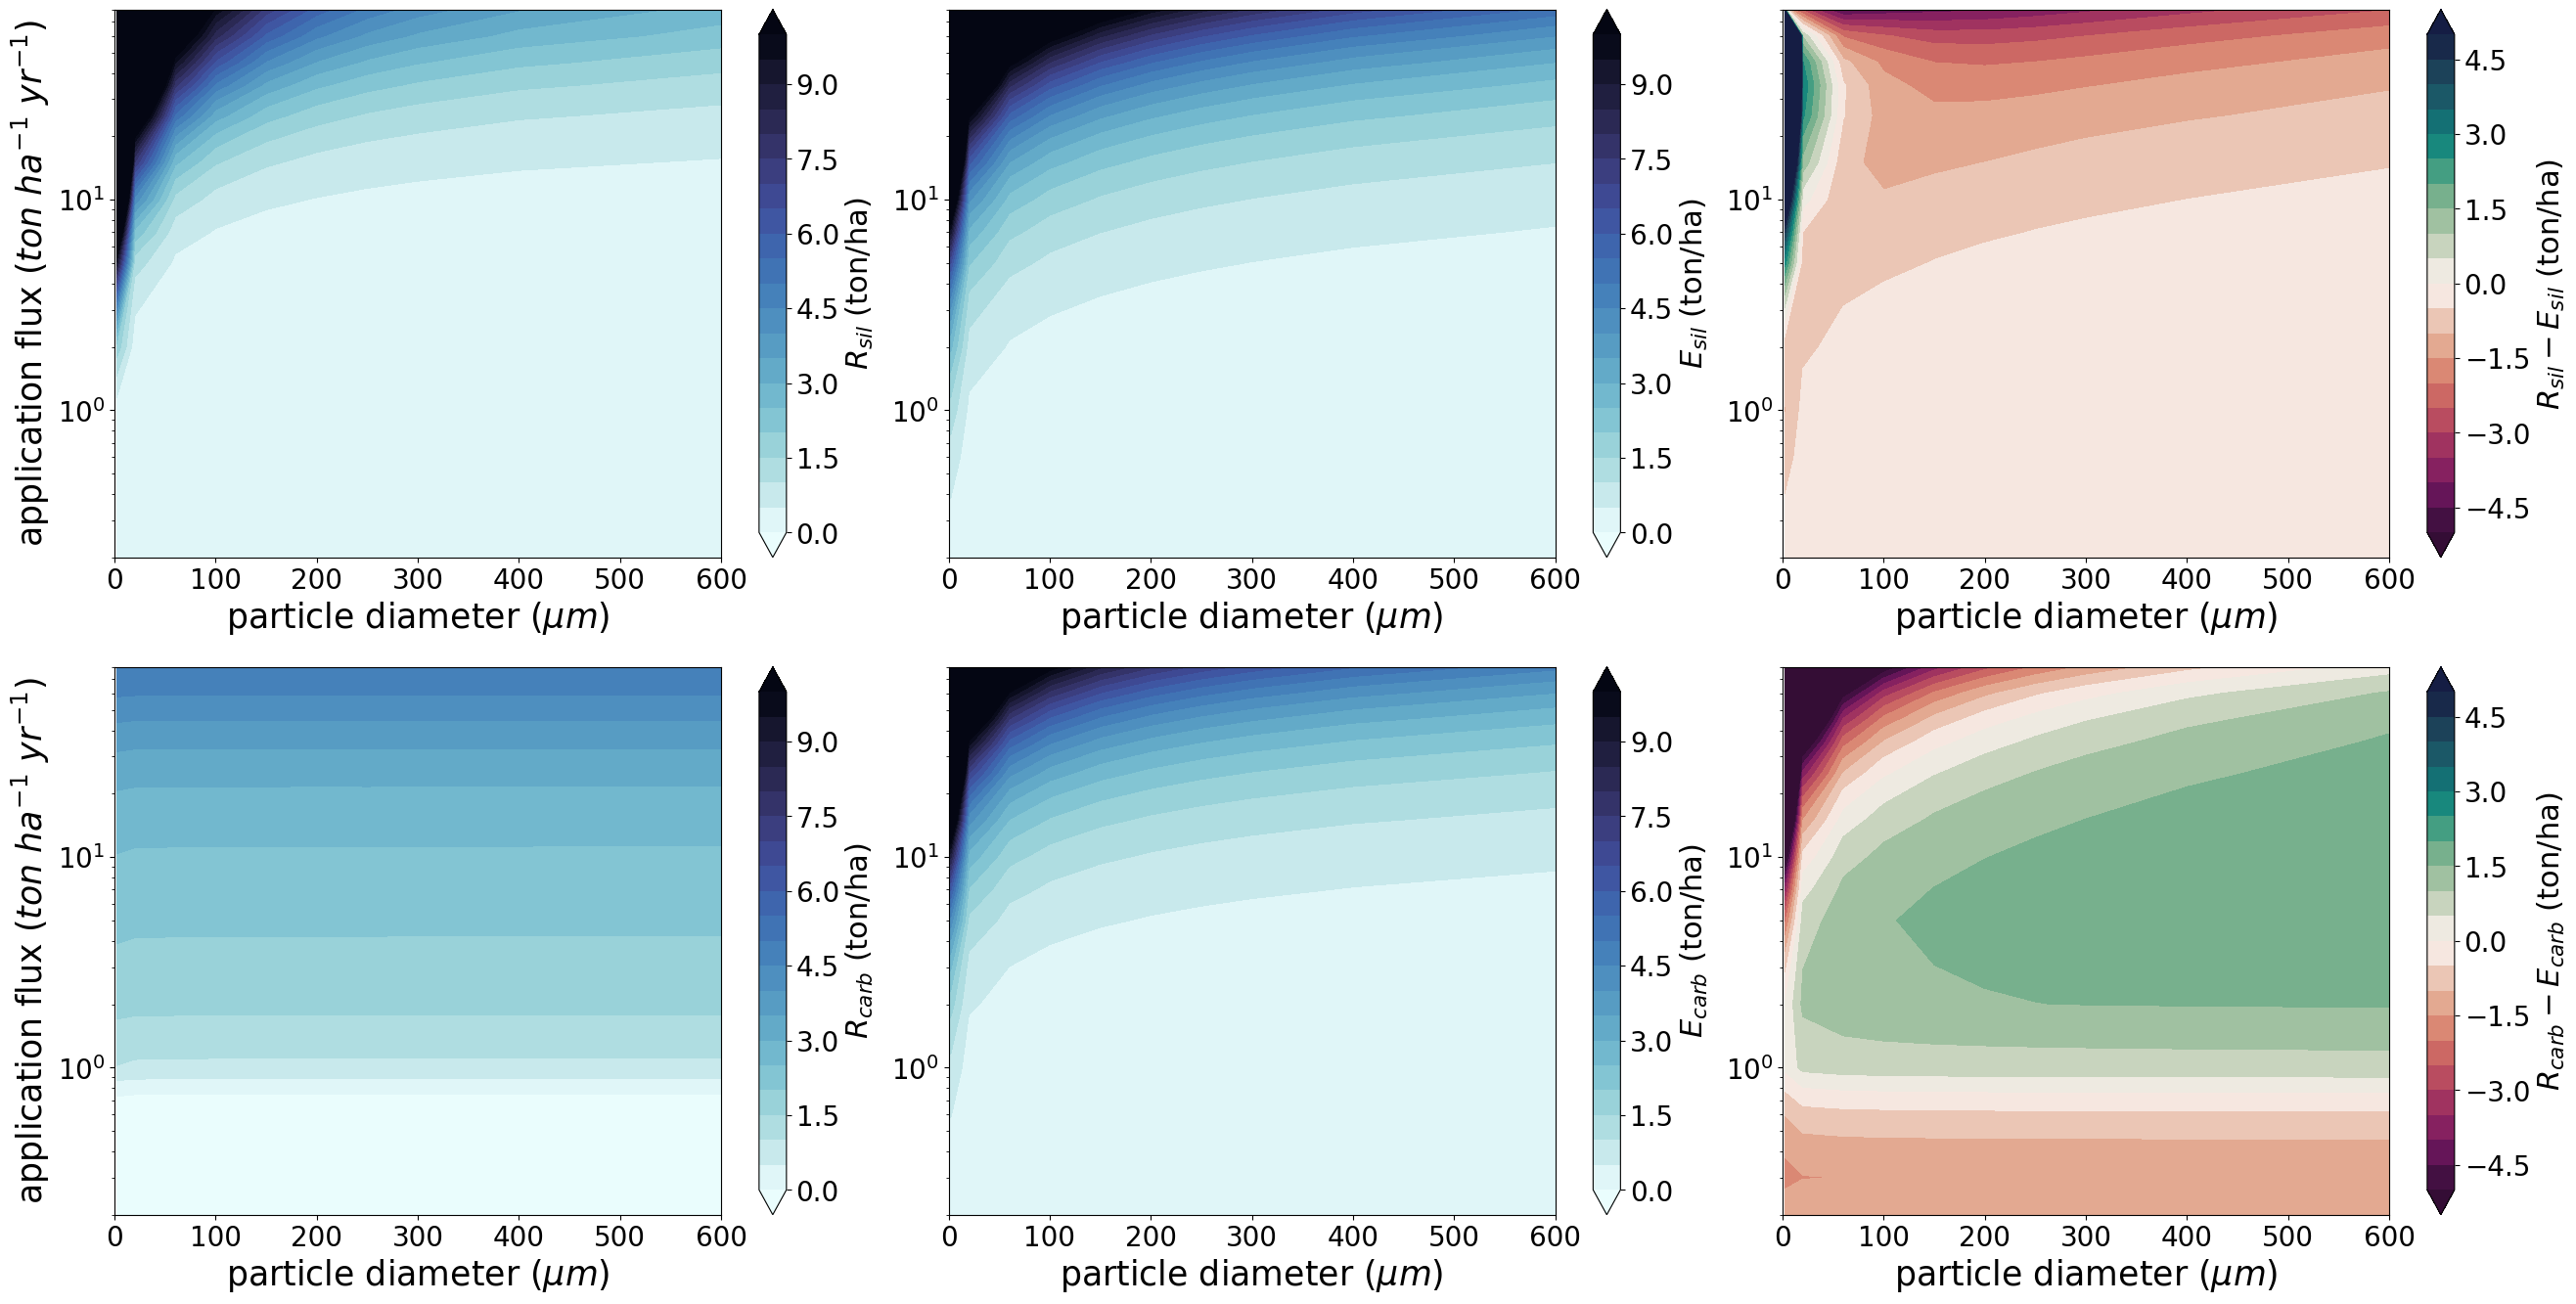

In [45]:
# --- PLOT decompose the silicate R and E 
# HIFERT ONLY
# set data conditions
loss_percent = 0
r_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg'  # 'co2pot_tot_tonHa_camg'
e_var = 'E_total_tonCO2_ha'
logX = False
logY = True

# pull out the data we want
dssil1_r = dssil1.sel(loss_percent=loss_percent, method='nearest')[r_var]
dssil1_e = dssil1.sel(loss_percent=loss_percent, method='nearest')[e_var]
dscc1_r = dscc1.sel(loss_percent=loss_percent, method='nearest')[r_var]
dscc1_e = dscc1.sel(loss_percent=loss_percent, method='nearest')[e_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dssil1_r = dssil1_r.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil1_e = dssil1_e.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_r = dscc1_r.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_e = dscc1_e.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col_r = cmo.ice_r
col_e = cmo.ice_r
col_net = cmo.curl_r 
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin_r, cmax_r = 0, 10
cmin_e, cmax_e = 0, 10
cmin_net, cmax_net = -5, 5
cbar_extend_r = "both"    # both, max, or min
cbar_extend_e = "both"    # both, max, or min
cbar_extend_net = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 80 
# *****************************

# x and y arrays
# [fertlevel 1]
xcc1 = dscc1_r['dustrad'].values
ycc1 = dscc1_r['dustrate_ton_ha_yr'].values
xsil1 = dssil1_r['dustrad'].values
ysil1 = dssil1_r['dustrate_ton_ha_yr'].values



# --- SET UP PLOT
spec = GridSpec(ncols=3, nrows=2, wspace=0.1)
fig = plt.figure(figsize=(32,16))

# --- fert level 1, sil, removal
ax = plt.subplot(spec[0])
contour = plt.contourf(xsil1*2, ysil1, dssil1_r.transpose(), levels=np.linspace(cmin_r, cmax_r, 21), 
                        cmap = col_r, vmin=cmin_r, vmax=cmax_r, extend=cbar_extend_r)
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fert level 1, sil, emissions
ax = plt.subplot(spec[1])
contour = plt.contourf(xsil1*2, ysil1, dssil1_e.transpose(), levels=np.linspace(cmin_e, cmax_e, 21), 
                        cmap = col_e, vmin=cmin_e, vmax=cmax_e, extend=cbar_extend_e)
cbar = plt.colorbar(contour)
cbar.set_label(r'$E_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fert level 1, sil, R minus E
ax = plt.subplot(spec[2])
contour = plt.contourf(xsil1*2, ysil1, dssil1_r.transpose() - dssil1_e.transpose(), levels=np.linspace(cmin_net, cmax_net, 21), 
                        cmap = col_net, vmin=cmin_net, vmax=cmax_net, extend=cbar_extend_net)
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{sil} - E_{sil}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)



# --- fert level 1, cc, removal
ax = plt.subplot(spec[3])
contour = plt.contourf(xcc1*2, ycc1, dscc1_r.transpose(), levels=np.linspace(cmin_r, cmax_r, 21), 
                        cmap = col_r, vmin=cmin_r, vmax=cmax_r, extend=cbar_extend_r)
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{carb}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fert level 1, cc, emissions
ax = plt.subplot(spec[4])
contour = plt.contourf(xcc1*2, ycc1, dscc1_e.transpose(), levels=np.linspace(cmin_e, cmax_e, 21), 
                        cmap = col_e, vmin=cmin_e, vmax=cmax_e, extend=cbar_extend_e)
cbar = plt.colorbar(contour)
cbar.set_label(r'$E_{carb}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fert level 1, cc, R minus E
ax = plt.subplot(spec[5])
contour = plt.contourf(xcc1*2, ycc1, dscc1_r.transpose() - dscc1_e.transpose(), levels=np.linspace(cmin_net, cmax_net, 21), 
                        cmap = col_net, vmin=cmin_net, vmax=cmax_net, extend=cbar_extend_net)
cbar = plt.colorbar(contour)
cbar.set_label(r'$R_{carb} - E_{carb}$ (ton/ha)', fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.title(ptext1, fontsize=fs_title)
# plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.xlabel(r"particle diameter $(\mu m)$", fontsize=fs_ylab)
plt.tick_params(axis='both', labelsize=fs_tick)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
